In [1]:
#in case of running this in colab 


from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#not included by default
!pip install rasterio 

     |████████████████████████████████| 19.1MB 159kB/s 


In [35]:
#imports 

from PIL import Image 
import gdal
import rasterio 
import pandas as pd
import numpy as np
from matplotlib import image as im
from matplotlib import pyplot as plt
from affine import Affine
from keras import layers
from keras import Input
import keras
import tensorflow as tf
from tensorflow.data import Dataset

In [4]:
label_path = "/content/drive/MyDrive/Honors/MapBiomas/C5-2019.tif"
#path to the MapBiomas land cover file from collection 5 in 2019 - here renamed C5-2019.tif

image_path = "/content/drive/MyDrive/Honors/MapBiomas/MAPBIOMAS-EXPORT/mosaic-2019-last-0000000000-0000000000.tif"
image_path1 = "/content/drive/MyDrive/Honors/MapBiomas/MAPBIOMAS-EXPORT/mosaic-2019-last-0000003328-0000000000.tif"


In [5]:
with rasterio.open(image_path) as image:
    print(image.profile)
with rasterio.open(label_path) as label:
    print(label.profile)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 3242, 'height': 3328, 'count': 102, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}
{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 3242, 'height': 3328, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False, 'interleave': 'band'}


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


For interpretation of these keys visit: https://rasterio.readthedocs.io/en/latest/quickstart.html

In [6]:
#another way of retrieving similar info
image.meta

{'count': 102,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'int32',
 'height': 3328,
 'nodata': None,
 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692),
 'width': 3242}

Text(0, 0.5, 'Row #')

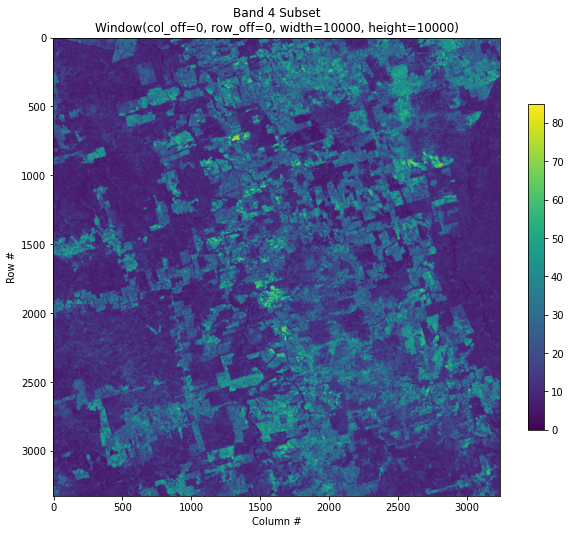

In [ ]:
#visualize part of the image

window = rasterio.windows.Window(0, 0, 10000, 10000)

with rasterio.open(image_path) as src:
    subset = src.read(1, window=window)

plt.figure(figsize=(10,12))
plt.imshow(subset)
plt.colorbar(shrink=0.5)
plt.title(f'Band 4 Subset\n{window}')
plt.xlabel('Column #')
plt.ylabel('Row #')

# Data generator

In [7]:
image.transform

Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692)

In [8]:
label.transform

Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)

In [9]:
transform = (0.00026949458523585647, 0.0, -73.98327050645874, 0.0, -0.00026949458523585647, 5.269697119701937)
transform = rasterio.Affine(transform[0],transform[1],transform[2],transform[3],transform[4],transform[5] )

In [10]:
kwargs = {
    'crs': {'init': 'epsg:4326'},
    'affine': Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692),
    'count': 1,
    'dtype': rasterio.int32,
    'driver': 'GTiff',
    'width': 3242,
    'height': 3328,
    'nodata': None
}
with rasterio.open(label_path, **kwargs) as out:
    print(out.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 3242, 'height': 3328, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0)}


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [11]:
out.meta

{'count': 1,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'int32',
 'height': 3328,
 'nodata': None,
 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0),
 'width': 3242}

In [12]:
image.meta

{'count': 102,
 'crs': CRS.from_epsg(4326),
 'driver': 'GTiff',
 'dtype': 'int32',
 'height': 3328,
 'nodata': None,
 'transform': Affine(0.00026949458523585647, 0.0, -55.80990315107875,
       0.0, -0.00026949458523585647, -6.617709035051692),
 'width': 3242}

In [13]:

print(image.bounds) #how much are edges of the image away from the reference coordinate point
print(image.crs) #coordinate system
image.count # 102 bands

BoundingBox(left=-55.80990315107875, bottom=-7.514587014716622, right=-54.936201705744104, top=-6.617709035051692)
EPSG:4326


102

In [45]:
def data_gen(src, lab, for_train: bool):
    '''
    generate labels to feed to the U-net
    filter the image using its several bands
    change the value for_train to False to use it for test data
    batch size could be added aswell, this version is used for debug for now
    '''
    
    #list of the selected bands
    bands = [2,4,6,14,35] # for example

    split_thresh = 0.8
    width = 158 # 158 = width/512
    height = 221 # 221 = height/512

    train_width = int(width*split_thresh)
    
    if for_train:
        for train_i in range(train_width):
            for train_j in range(height):
                train_window = rasterio.windows.Window(int(train_i*512),int(train_j*512), int((train_i*512)+512), int((train_j*512)+512))
                img_crop = np.zeros((512, 512, len(bands)))
                # filter the bands
                for i, band in enumerate(bands):
                    img_crop[:,:,i] = src.read(band, window=train_window)
                label_crop = lab.read(1, window=train_window).reshape((512, 512, 1))
                
                yield (img_crop, label_crop)
                
    else:
        for test_i in range(train_width, width): # the rest 20% part of the image
            for test_j in range(height):
                test_window = rasterio.windows.Window(int(test_i*512),int(test_j*512), int((test_i*512)+512), int((test_j*512)+512))
                img_crop = np.zeros((512, 512, len(bands)))
                for i, band in enumerate(bands):
                    img_crop[:,:,i] = src.read(band, window=test_window)
                label_crop = lab.read(1, window=train_window).reshape((512, 512, 1))
                
                yield (img_crop, label_crop)

In [46]:
def make_batches(size, src, lab, for_train):
  """
  converts the python generator into a tf.data.Dataset object
  and builds batches for of data
  """
  gen = lambda: (row for row in data_gen(src, lab, for_train))
  dataset = Dataset.from_generator(gen, output_types=(tf.float32, tf.float32))
  dataset = dataset.batch(size)
  return(dataset)


In [47]:
def build_model(input_layer, start_neurons):
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    pool1 = layers.Dropout(0.25)(pool1)

    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = layers.MaxPooling2D((2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = layers.Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = layers.Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = layers.concatenate([deconv4, conv4])
    uconv4 = layers.Dropout(0.5)(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = layers.Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = layers.Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = layers.concatenate([deconv3, conv3])
    uconv3 = layers.Dropout(0.5)(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = layers.Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = layers.Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = layers.concatenate([deconv2, conv2])
    uconv2 = layers.Dropout(0.5)(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = layers.Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = layers.Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = layers.concatenate([deconv1, conv1])
    uconv1 = layers.Dropout(0.5)(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = layers.Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = layers.Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input(shape=(512,512,1))
output_layer = build_model(input_layer, 64)

In [48]:
model = keras.Model(inputs=input_layer, outputs=output_layer)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = 0.001),
    loss='categorical_crossentropy'
    )

In [49]:
label = rasterio.open(label_path, **kwargs)
image = rasterio.open(image_path)

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:207: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [50]:
model.fit(make_batches(10, image, label, for_train = True), validation_data = make_batches(10, image, label, for_train=False), epochs=2)

Epoch 1/2


InvalidArgumentError: ignored